## Reference

https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html#Extract-8x8-block-and-look-at-its-DCT-coefficients

In [1]:
from io import BytesIO
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from scipy.fftpack import dctn
from scipy.fftpack import idctn

In [2]:
pylab.rcParams['figure.figsize'] = (10, 10)

## Download image (not be saved on storage)

In [3]:
image_url = 'https://homepages.cae.wisc.edu/~ece533/images/frymire.png'

image = np.asarray(
    Image.open(BytesIO(requests.get(image_url).content)).convert("L").resize((512, 512))
)

## Display image

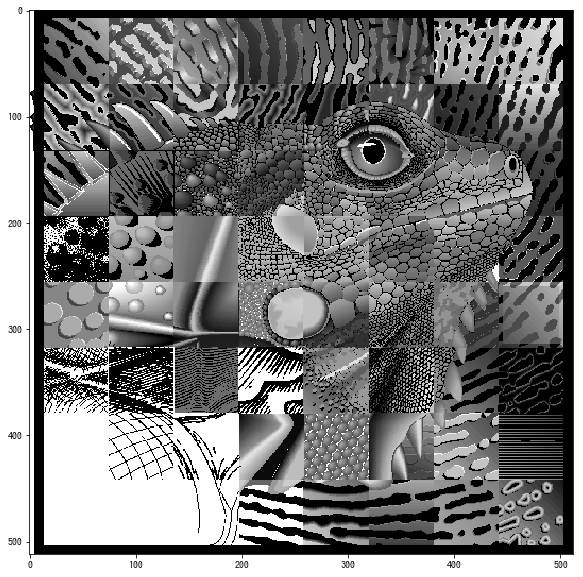

In [4]:
plt.imshow(image, cmap='gray')

plt.show()

## Define blockwise DCT and IDCT

In [5]:
def divide_into_blocks(x, block_shape):
    row, col = x.shape
    b_row, b_col = block_shape

    assert row % b_row == 0 and col % b_col == 0, \
                f'cannot divide input 2-D array by block size {block_shape}'
    
    return x.reshape(row // b_row, b_row, col // b_col, b_col)


def dct_blockwise(x, block_shape, **kwds):
    divided = divide_into_blocks(x, block_shape)

    return dctn(divided, axes=(1, 3), **kwds).reshape(x.shape)


def idct_blockwise(x, block_shape, **kwds):
    divided = divide_into_blocks(x, block_shape)

    return idctn(divided, axes=(1, 3), **kwds).reshape(x.shape)

## Perform a blockwise DCT

In [6]:
dct = dct_blockwise(image, (8, 8), norm='ortho')

## Display all DCT blocks

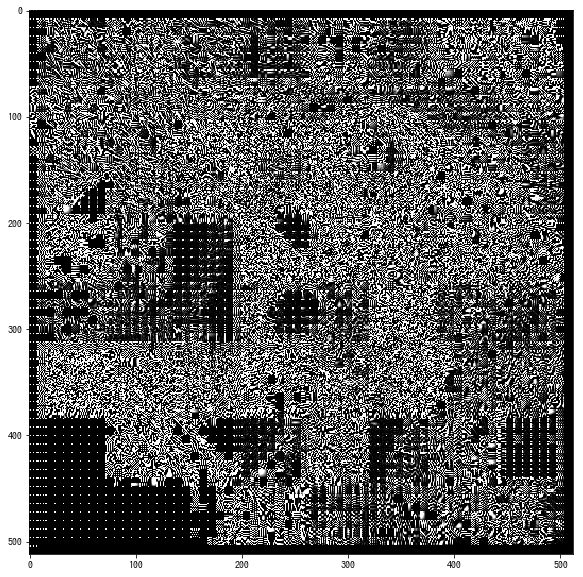

In [7]:
plt.imshow(dct, cmap='gray', vmax = np.max(dct) * 0.01,vmin = 0)

plt.show()

## Threshold DCT coefficients

In [8]:
thresholds = 0.012, 0.192
dct_thresh_list = []

for th in thresholds:
    dct_thresh_list.append(np.where(np.abs(dct) < th * dct.max(), 0, dct))

## Display all DCT blocks thresholded

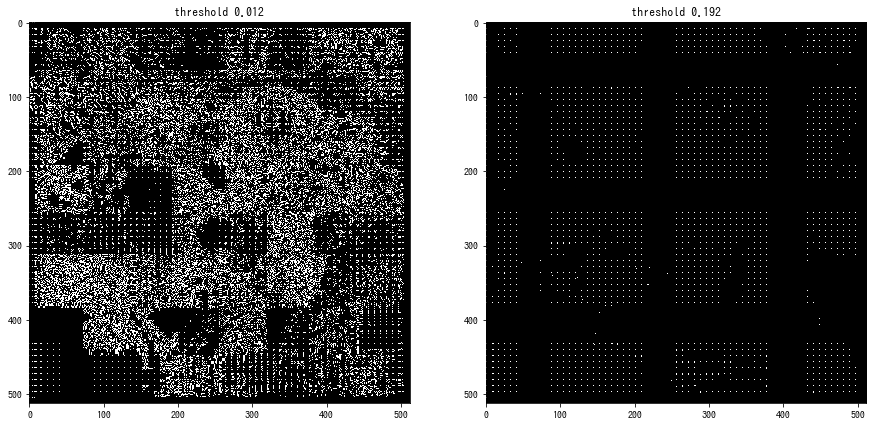

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

for a, th, dct_thresh in zip(axes, thresholds, dct_thresh_list):
    a.imshow(dct_thresh, cmap='gray', vmax = np.max(dct)*0.01, vmin = 0)
    a.set_title(f'threshold {th}')

plt.show()

In [10]:
print('threshold', '|', 'keep DCT coefficients [%]')
percents = []

for th, dct_thresh in zip(thresholds, dct_thresh_list):
    percent_nonzeros = (np.count_nonzero(dct_thresh) / dct_thresh.size) * 100
    percents.append(percent_nonzeros)
    
    print('-' * 40)
    print(th, '      |', '{:.3f}'.format(percent_nonzeros))

threshold | keep DCT coefficients [%]
----------------------------------------
0.012       | 38.232
----------------------------------------
0.192       | 1.456


## Compare DCT compressed image with original

In [11]:
compressed_list = []

for dct_thresh in dct_thresh_list:
    compressed_list.append(idct_blockwise(dct_thresh, (8, 8), norm='ortho'))
    
gradation = []
row, col = image.shape
images = [image] + compressed_list
num_images = len(images)
width = col // num_images

for i, img in enumerate(images):
    gradation.append(img[:, i * width : (i + 1) * width])

gradation = np.hstack(gradation)

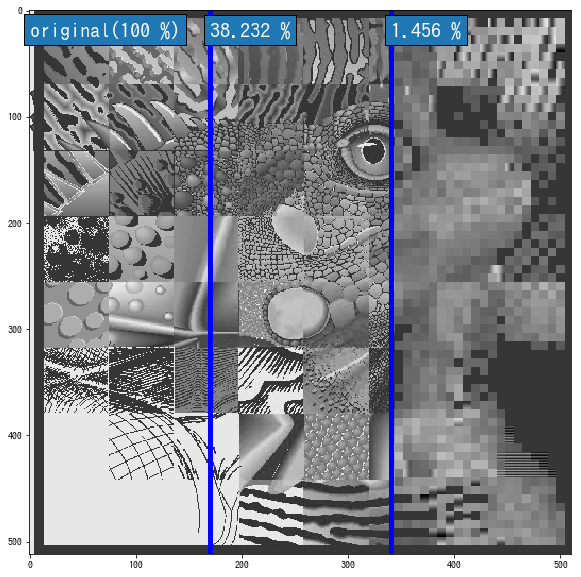

In [12]:
plt.imshow(gradation, cmap='gray')

for i in range(len(images)):
    line_x = width * i
    if i:
        plt.plot([line_x, line_x], [0, row - 1], 'b-', lw=5)
        text = '{:.3f} %'.format(percents[i - 1])
    else:
        text = 'original(100 %)'
    plt.text(line_x, 25, text, size=20, color='w', bbox={'boxstyle': 'square'})

plt.show()